<a href="https://colab.research.google.com/github/markusdiekmann95/Morph-U-Net/blob/main/MorphCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook was used to test the feasibility of MorphNet functions on a simple CNN. The Preprocessing and the Modeling is based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and adjusted by myself.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


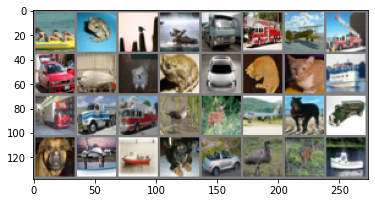

ship  frog  bird  deer  truck truck plane truck car   plane dog   frog  car   cat   cat   ship  truck truck truck bird  deer  plane horse truck dog   plane ship  dog   car   bird  deer  ship 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def conv(a,b):
  convi = nn.Sequential(
    nn.Conv2d(a, b, 3,  stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(b)
  )
  return convi

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(3,32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = conv(32, 64)
        self.conv3 = conv(64, 128)
        self.conv4 = conv(128, 256)
        self.conv5 = conv(256, 256)
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.pool(x) 
        x = self.conv5(x)


        x = self.pool(x) 
    
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
     #   x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [ ]:
def model_size_C(layer):
  if not len(layer.size())==4:
    "Wrong Layer! Len of Size must be 4!"
  res = torch.tensor(0.)
  x = torch.Tensor(2)
  x[0] = torch.tensor([layer.shape[2]])
  x[1] = torch.tensor([layer.shape[3]])
  res = torch.prod(x)
  return res.cuda()

def l1_reg(layer):
  ''' L1 Regularization'''
  l1 = 0
  for param in layer:
    l1 += torch.sum(torch.abs(param))
  return l1

def zero_out_indicator(layer, threshold=0.0001):
  '''Indicator if a neuron is alive or not'''
  res = torch.Tensor(layer.size()).cuda()
  al = 0
  for param in layer:
    i = 0
    res[i] = param
  res = res.where(layer.abs() > torch.tensor(threshold).cuda(), torch.tensor(0.).cuda())
  res = layer.where(layer.abs() < torch.tensor(0.).cuda(), torch.tensor(1.).cuda())
  al = torch.sum(res)
  return al

def gamma_regularizer(model, C, threshold=0.0001):
  '''MorphNet Gamma Regularization'''
  last_module = None
  costs = 0.
  for module in model.modules():
    if isinstance(module, nn.Sequential):
      if last_module is None:
        #Input
        costs += C(module[0].weight) * zero_out_indicator(module[2].weight, threshold) * 0 #Model Input - has no gammas

        #Output
        costs += C(module[0].weight) * l1_reg(module[2].weight) * 3 #First Batchnorm gammas in double conv block, Input channels are always alive!


        last_module = module
      else:
        #Input
        costs += model_size_C(module[0].weight) * l1_reg(last_module[2].weight) * zero_out_indicator(module[2].weight, threshold) #First Batchnorm gammas in double conv block

        #Output
        costs += model_size_C(module[0].weight) * l1_reg(module[2].weight) * zero_out_indicator(last_module[2].weight, threshold) #First Batchnorm gammas in double conv block


        last_module = module
  
  return costs

In [ ]:
net = Net()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
net.to(device)

Device cuda


Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0)

In [ ]:
for module in net.modules():
  if isinstance(module, nn.Sequential):
    print(module)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        MaxPool2d-14            [-1, 25

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.9)



In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    costs = 0.
    running_loss = 0.0
    print(epoch)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()


        # forward + backward + optimize
        outputs = net(inputs)
        costs = gamma_regularizer(net, model_size_C, threshold=0.001)
        loss = criterion(outputs, labels) + 1e-4 * costs
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

0
1
2
3
4
5
6
7
8
9
Finished Training


In [ ]:
for module in net.modules():
   if isinstance(module, nn.Sequential):
    print(module[2].weight)


Parameter containing:
tensor([ 1.4031e-02,  3.5764e-02,  8.8962e-03,  1.6985e-02,  1.6073e-03,
        -8.0300e-04,  2.4940e-02,  1.7373e-03,  3.6184e-02, -2.1100e-03,
         1.9442e-03,  8.0460e-05,  2.1905e-02,  1.6425e-02,  3.9367e-02,
        -1.7771e-04,  2.3945e-02,  8.0588e-04,  2.1652e-02,  1.4001e-03,
         7.7778e-04,  2.7623e-02,  3.0861e-02,  7.0958e-03, -1.4679e-04,
         1.3617e-02,  5.3555e-04,  7.7426e-04,  2.6959e-02,  1.4334e-02,
         7.6519e-03,  2.3640e-02], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.0516e-03,  5.8061e-04,  4.0374e-04,  1.8867e-04,  1.5600e-03,
         3.4493e-03,  9.0476e-03, -9.7267e-05,  1.5415e-04,  1.0951e-02,
         1.9474e-02, -6.1093e-05, -9.0802e-04,  1.0577e-03,  2.3941e-03,
        -3.2298e-04,  1.2082e-04, -8.9934e-05, -9.7003e-04,  1.3725e-02,
        -2.7541e-03,  4.4688e-05,  1.4693e-04,  5.5685e-03,  6.5523e-03,
         1.3807e-02, -9.0961e-05,  1.2973e-02, -2.8223e-04, -6.1316e-04,
        

In [ ]:
def sparsify(weights, threshold=0.0001):
  '''
  @weights: all weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: weights where dead weights are zero
  '''
  w = weights.cpu()
  res = w.where(w.abs() > torch.tensor(threshold).cpu(), torch.tensor(0.).cpu())
  return res

def percentage_waste(layer, threshold=0.0001):
  w = layer.weight
  sparsified_w = sparsify(w, threshold)
  if sparsified_w.max() == 0:
    return 1.
  non_sparse_w = torch.nonzero(sparsified_w)

  return 1-(non_sparse_w.numel()/(w.numel()+1e-10))

In [ ]:
i = 0
for module in net.modules():
   if isinstance(module, nn.Sequential):    
    print(sparsify(module[2].weight))
    i += 1
    if i == 2:
      break

tensor([ 0.0140,  0.0358,  0.0089,  0.0170,  0.0016, -0.0008,  0.0249,  0.0017,
         0.0362, -0.0021,  0.0019,  0.0000,  0.0219,  0.0164,  0.0394, -0.0002,
         0.0239,  0.0008,  0.0217,  0.0014,  0.0008,  0.0276,  0.0309,  0.0071,
        -0.0001,  0.0136,  0.0005,  0.0008,  0.0270,  0.0143,  0.0077,  0.0236],
       grad_fn=<SWhereBackward0>)
tensor([-0.0011,  0.0006,  0.0004,  0.0002,  0.0016,  0.0034,  0.0090,  0.0000,
         0.0002,  0.0110,  0.0195,  0.0000, -0.0009,  0.0011,  0.0024, -0.0003,
         0.0001,  0.0000, -0.0010,  0.0137, -0.0028,  0.0000,  0.0001,  0.0056,
         0.0066,  0.0138,  0.0000,  0.0130, -0.0003, -0.0006,  0.0000,  0.0154,
         0.0005,  0.0002,  0.0149,  0.0004,  0.0000,  0.0076, -0.0001, -0.0019,
         0.0000,  0.0106,  0.0111,  0.0002,  0.0020, -0.0015,  0.0082,  0.0074,
         0.0033,  0.0000,  0.0123, -0.0150,  0.0167, -0.0001,  0.0091, -0.0034,
        -0.0003, -0.0006,  0.0123, -0.0011,  0.0009, -0.0019,  0.0000,  0.0067],
    

In [ ]:
for module in net.modules():
   if isinstance(module, nn.Sequential):
    print(percentage_waste(module[2]))

0.031250000003027356
0.1562500000013184
0.36718750000049427
0.3476562500002548
0.36718750000024714


In [ ]:
weights = []

for module in net.modules():
  if isinstance(module, nn.Sequential):
    for x in module[2].weight:
      weights.append(x.detach().cpu().numpy())

In [ ]:
weights = np.vstack(weights)

In [ ]:
np.min(weights)

0.4295117

In [ ]:
def new_layers_in_percentage(model, threshold=0.0001):
  ''' Returns the new layer sizes in percentage'''
  len = 0
  for module in model.modules():
    if isinstance(module, nn.Sequential):
      len += 1
  layer_reduction = np.zeros(len)
  i = 0
  for module in model.modules():
    if isinstance(module, nn.Sequential):
      layer_reduction[i] = 1. - percentage_waste(module[2], threshold)
      i += 1
  return layer_reduction


In [ ]:
new_layers_in_percentage(net)

array([0.9375  , 0.96875 , 0.984375])

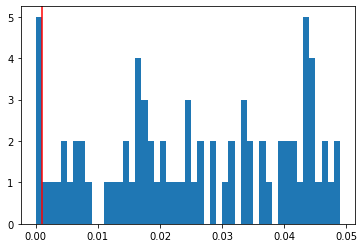

In [ ]:
#np.histogram(weights)
plt.hist(np.abs(weights), bins=np.arange(0, 0.05, 0.001)) 
plt.axvline(0.001, color="red")
plt.show()

In [ ]:
len(np.where(weights < 0.001)[0])

708

In [ ]:
len(weights)

864

In [ ]:
len(np.where(weights > 0.001)[0])

156